In [71]:
!pip install zipcode
!pip install uszipcode
!pip install xlrd

### Since the city San Francisco is spelled different ways in the datasset, we just use another dataset containing San Francisco zipcodes to compare with the SF Business Dataset to extract all the businesses from San Francisco  without the hassle of string search

In [72]:
import pandas as pd
import numpy as np

sf_business_dataset = pd.read_csv("sf_business_dataset.csv", encoding='latin-1')
zip_codes_sf = pd.read_excel("zip_codes.xlsx")

In [73]:
sf_business_dataset.head()

Location Id  Business Account Number       Ownership Name DBA Name  \
0  0026883-11-001                    26883  Chevron Texaco Corp  Chevron   
1  0026883-12-001                    26883  Chevron Texaco Corp  Chevron   
2  0026883-13-001                    26883  Chevron Texaco Corp  Chevron   
3  0026883-15-001                    26883  Chevron Texaco Corp  Chevron   
4  0026883-16-001                    26883  Chevron Texaco Corp  Chevron   

       Street Address           City State  Source Zipcode  \
0    2998 San Jose Av  San Francisco    CA         94112.0   
1  301 Claremont Blvd  San Francisco    CA         94127.0   
2     3675 Geary Blvd  San Francisco    CA         94118.0   
3     2301 Lombard St  San Francisco    CA         94123.0   
4        1288 19th St  San Francisco    CA         94107.0   

  Business Start Date Business End Date  \
0           10/1/1968               NaN   
1           10/1/1968               NaN   
2           10/1/1968               NaN   
3           10/1/1968               NaN   
4           10/1/1968               NaN   

                         ...                         NAICS Code  \
0                        ...                                NaN   
1                        ...                                NaN   
2                        ...                                NaN   
3                        ...                                NaN   
4                        ...                                NaN   

  NAICS Code Description Parking Tax Transient Occupancy Tax LIC Code  \
0                    NaN       False                   False      NaN   
1                    NaN       False                   False      NaN   
2                    NaN       False                   False      NaN   
3                    NaN       False                   False      NaN   
4                    NaN       False                   False      NaN   

  LIC Code Description Supervisor District  \
0                  NaN                11.0   
1                  NaN                 7.0   
2                  NaN                 1.0   
3                  NaN                 2.0   
4                  NaN                10.0   

  Neighborhoods - Analysis Boundaries  Business Corridor  \
0          Oceanview/Merced/Ingleside                NaN   
1                  West of Twin Peaks                NaN   
2                   Lone Mountain/USF                NaN   
3                              Marina                NaN   
4                        Potrero Hill                NaN   

                                   Business Location  
0  2998 SAN JOSE AV\rSan Francisco, CA 94112\r(37...  
1  301 CLAREMONT BLVD\rSan Francisco, CA 94127\r(...  
2  3675 GEARY BLVD\rSan Francisco, CA 94118\r(37....  
3  2301 LOMBARD ST\rSan Francisco, CA 94123\r(37....  
4  1288 19TH ST\rSan Francisco, CA 94107\r(37.761...  

[5 rows x 26 columns]

# Q1

## To identify high concentration of businesses in particular pockets of San Francisco

In [74]:
# Get Active Businesses by taking only those businesses having no end date

active_business = sf_business_dataset.loc[sf_business_dataset["Business End Date"].isnull(),:]
active_business.shape

(172670, 26)

### Once we derive the businesses having no end date, we are assured that they are still active and have not closed down. Going down we narrow down those businesses to San Francisco.

In [75]:
# Get Active Businesses in San Francisco by comparing sf_business_dataset and zip_codes dataset

active_business_sf = active_business.loc[active_business["Source Zipcode"].isin(zip_codes_sf["zip"]),:]
active_business_sf["Source Zipcode"] = active_business_sf["Source Zipcode"].astype(int)

active_business_sf.shape

C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(135031, 26)

### We remove null entries of businesses whose location is not specified.

In [76]:
# Gather Business whose Business Location is specfied
active_business_sf_notnull = active_business_sf[active_business_sf["Business Location"].notnull()]
active_business_sf_notnull.shape

(114423, 26)

In [77]:
# To count number of businesses having null Business Location
active_business_sf["Business Location"].isnull().sum()

20608

### We see that only a minor portion of businesses do not have location specified. We then extract map coordinates from 'Business Location' attribute to plot on a map.

In [78]:
# Extract Lat & Long for Businesses having not null location

import re
lat_lon = []
def get_lat_lon(x):
    #print (x)
    z = re.search(r"[^[]*\(([^]]*)\)", x)
    if z is None:
        lat_lon.append('')
    else :
        lat_lon.append(z.group(1))
        
active_business_sf_notnull["Business Location"].apply(get_lat_lon)
len(lat_lon)

114423

### Split the coordinates column into latitude and longitude for map plot.

In [79]:
# New column in active_business_sf_notnull for Latitude & Longitude
active_business_sf_notnull = active_business_sf_notnull.assign(lat_lon = lat_lon)
active_business_sf_notnull["lat_lon"].head()

0     37.711486, -122.45562
1      37.7405, -122.465095
2    37.781224, -122.458531
3    37.799337, -122.439665
4    37.761371, -122.395368
Name: lat_lon, dtype: object

### We create a seperate dataframe having no null values of latitude and longitude 

In [80]:
# Split Latitude and Longitude into seperate column

new = active_business_sf_notnull["lat_lon"].str.split(',',n=2, expand = True)

# Drop NAs and None
new = new.replace([" ","",'None'], np.nan)
new = new.mask(new.eq('None')).dropna()

new.columns = ["lat","lon"]

new.head(5)

lat           lon
0  37.711486    -122.45562
1    37.7405   -122.465095
2  37.781224   -122.458531
3  37.799337   -122.439665
4  37.761371   -122.395368

### We then extract the missing coordinates from zipcode and fill the missing 20608 values with coordinates stored in a seperate dataframe.

In [81]:
## Get the info where Business Location == NULL 

from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
#zip_code = search.by_zipcode('95050')
#zip_code

In [82]:
active_business_sf_isnull = active_business_sf[active_business_sf["Business Location"].isnull()]

In [83]:
# For 20k missing locations
active_business_sf_isnull["Source Zipcode"] = active_business_sf_isnull["Source Zipcode"].astype(int)
lat = active_business_sf_isnull["Source Zipcode"].map(lambda x : search.by_zipcode(x).to_dict()['lat'])
lng = active_business_sf_isnull["Source Zipcode"].map(lambda x : search.by_zipcode(x).to_dict()['lng'])

C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Compare the size of the 3 dataframes created from the start.
### all_new is the final dataframe we are going to use as it does not have any empty latitude and longitude values.

In [84]:
new1 = pd.DataFrame(list(zip(lat.values.tolist(), lng.values.tolist())), columns= ["lat","lon"])
all_new = new.append(new1)
new.shape, new1.shape, all_new.shape

((112822, 2), (20608, 2), (133430, 2))

### We the drop the NA's and none to check the final length of all_new dataset. It comes down from 133430 to 128016

In [85]:
# Drop NAs,None and then check shape of coordinate dataset
all_new = all_new.replace([" ","",'None'], np.nan)
all_new = all_new.mask(new.eq('None')).dropna()
all_new.shape

(128016, 2)

In [86]:
all_new.head()

lat           lon
0  37.711486    -122.45562
1    37.7405   -122.465095
2  37.781224   -122.458531
3  37.799337   -122.439665
4  37.761371   -122.395368

In [87]:
#Convert datatype to numeric
all_new = all_new.apply(pd.to_numeric)
all_new.dtypes

lat    float64
lon    float64
dtype: object

### We convert the datatype of lat and lon to numeric so that folium does not consider them as string and throw error while plotting on map.

In [88]:
# Determine count of business within each zipcode
active_business_sf["Source Zipcode"].value_counts()

94110    10455
94103     9755
94107     8355
94109     8138
94102     7145
94111     6028
94118     6013
94122     5890
94105     5683
94117     5661
94124     5614
94114     5568
94112     5542
94115     5464
94133     5454
94104     4989
94108     4977
94123     4919
94121     4343
94116     3544
94131     2759
94134     2473
94132     2209
94127     2167
94129      534
94158      519
94130      494
94188       67
94119       44
94142       39
94147       30
94143       24
94159       22
94120       21
94164       19
94141       19
94126       15
94140       11
94125        8
94137        6
94146        6
94177        5
94145        1
94144        1
94163        1
Name: Source Zipcode, dtype: int64

### We plot the the number of businesses by zipcode so as to get an estimate of difference in the quantity of business across each zipcode.

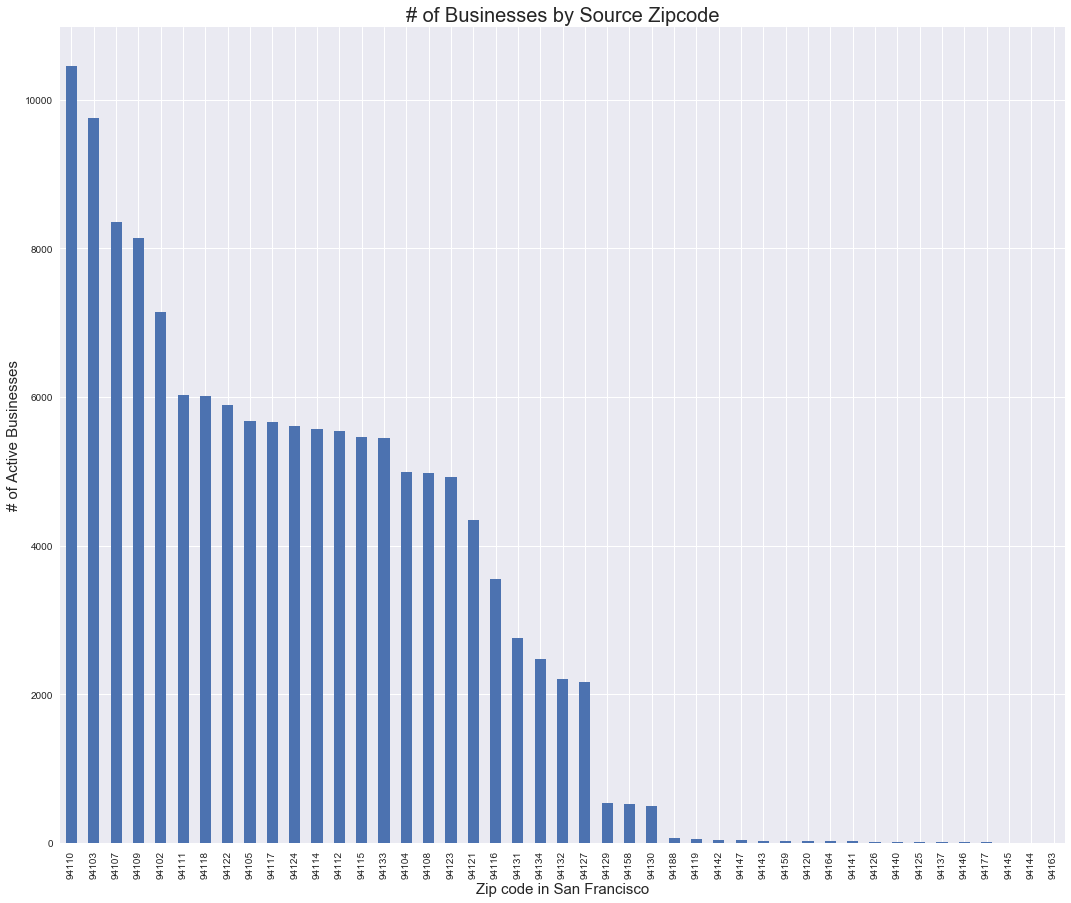

In [89]:
% matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 15))
plt.title("# of Businesses by Source Zipcode", fontsize = 20)
plt.xlabel("Zip code in San Francisco", fontsize = 15)
plt.ylabel("# of Active Businesses", fontsize = 15)
active_business_sf["Source Zipcode"].value_counts().plot.bar()

### The areas in San Francisco with the highest number of businesses are:-
#### 94110 - Inner Mission/Bernal Heights
#### 94103 - South of Market
#### 94107 - Potrero Hill
#### 94109 - Polk/Russian Hill (Nob Hill)
#### 94102 - Hayes Valley/Tenderloin/North of Market

In [109]:
!pip install folium

In [110]:
import folium
from folium import plugins
from folium import features
import seaborn as sns

map = folium.Map(location=[37.711486,-122.45562], zoom_start=15)
map


In [111]:
lats =[]
lons =[]
for each in all_new[0:len(all_new)].iterrows():
     lat = each [1]['lat']
     lats.append(lat)
     lon = each [1]['lon']
     lons.append(lon)
locations = list(zip(lats,lons))

map = folium.Map(location =[all_new['lat'].mean(),all_new['lon'].mean()],zoom_start =13)
folium.CircleMarker(location=locations ,radius=5).add_to(map)
map

In [112]:
#map = folium.Map(location =[all_new['lat'].mean(),all_new['lon'].mean()],zoom_start =13)

latitude =[]
longitude =[]
lat = all_new['lat']
lon = all_new['lon']

#map
latitude = list(lat.values)
longitude = list(lon.values)

locations = list(zip(latitude,longitude))


map = folium.Map(location = [all_new['lat'].mean(),  all_new['lon'].mean()], zoom_start=12)

for i in locations:
  folium.CircleMarker(location=i ,radius = 8, color = '#3186cc', fill_color='#3186cc').add_to(map)

map


KeyboardInterrupt: 

In [114]:
map = folium.Map(location =[all_new['lat'].mean(),all_new['lon'].mean()],zoom_start =13)
for i in [(37.811486, -122.47562), (37.711486, -122.45562)]:
  folium.CircleMarker(location =  i, radius = 5, color = '#3186cc', fill_color='#3186cc').add_to(map)
map

In [113]:
map = folium.Map(location =[all_new['lat'].mean(),all_new['lon'].mean()],zoom_start =13)
for i in locations[:2000]:
  folium.CircleMarker(location =  i, radius = 5, color = '#3186cc', fill_color='#3186cc').add_to(map)
map

# Q2. 

## Determine the NAICS code and description of businesses to be benefitted from the tax break scheme

In [90]:
# Determine null values and number of businesses in each industry
active_business_sf["NAICS Code Description"].value_counts(dropna=False)

NaN                                                 45959
Real Estate and Rental and Leasing Services         18937
Professional, Scientific, and Technical Services    15689
Retail Trade                                         8753
Food Services                                        7197
Transportation and Warehousing                       7014
Private Education and Health Services                5467
Construction                                         5039
Arts, Entertainment, and Recreation                  4919
Accommodations                                       3352
Financial Services                                   2945
Information                                          2501
Wholesale Trade                                      2486
Administrative and Support Services                  2353
Manufacturing                                        1293
Certain Services                                      540
Insurance                                             487
Utilities     

### We have 45,959 entries which are empty with respect to NAICS Code Description which is significantly high.

In [91]:
#Find number of null values in each attribute
sf_business_dataset.isnull().sum()

Location Id                                 0
Business Account Number                     0
Ownership Name                              0
DBA Name                                    0
Street Address                              4
City                                      269
State                                     680
Source Zipcode                             97
Business Start Date                         0
Business End Date                      172670
Location Start Date                         0
Location End Date                      156405
Mail Address                                2
Mail City                                  52
Mail Zipcode                              130
Mail State                                119
NAICS Code                              87716
NAICS Code Description                  90199
Parking Tax                                 0
Transient Occupancy Tax                     0
LIC Code                               206758
LIC Code Description              

### We calculate null values based on both NAICS Code and Description entries. As the dataframe gives very lower number of null values, we go ahead to plot a bar graph for strength of industries based on number of businesses.

In [92]:
# Calculate null values in both NAICS Code and NAICS Code Description Values
active_business_sf[active_business_sf["NAICS Code Description"].isnull() & active_business_sf["NAICS Code"]].shape

(2245, 26)

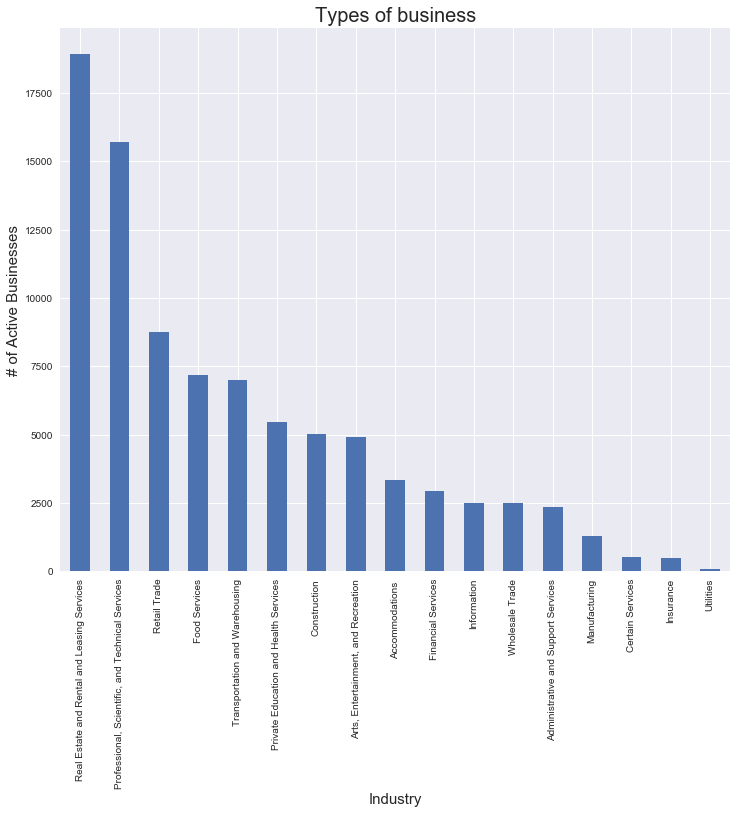

In [93]:
# Plot a graph of strength of business in each industry
% matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
plt.title("Types of business", fontsize = 20)
plt.xlabel("Industry", fontsize = 15)
plt.ylabel("# of Active Businesses", fontsize = 15)
active_business_sf["NAICS Code Description"].value_counts().plot.bar()

### We can see the graph plotted and conclude that Utilities, Insurance, Certain Services, Manufacturing are the least popular industry categories in which businesses have come up in. We do not consider the 3-4 categories after Manufacturing as they are very similar in terms of number of businesses and it is a waste of resources to compare them. 
### We can compare them if the analysis is to be done more deeply and on a minute basis.

In [94]:
# Creating a dataframe consisting of last 4 industry by business numbers and comparing it with the active businesses in San 
# Francisco dataset
less_pop=["Utilities","Insurance","Certain Services", "Manufacturing"]
df_less_pop=active_business_sf[active_business_sf["NAICS Code Description"].isin(less_pop)]
active_business_sf.shape,df_less_pop.shape

((135031, 26), (2420, 26))

### Above, we can see a comparison of the total number of businesses which are active in San Francisco to those which come in the above 4 categories.

# Active Businesses in Less popular industries by Year 

In [95]:
# Creating a dataframe consisting of active businesses from the bottom 4 popular industries
df_less_pop=active_business_sf[active_business_sf["NAICS Code Description"].isin(less_pop)]

In [96]:
# We get the NAICS code and the size
df_less_pop.groupby(['NAICS Code',"NAICS Code Description"]).size()

NAICS Code  NAICS Code Description
2200-2299   Utilities                  100
3100-3399   Manufacturing             1293
5240-5249   Insurance                  487
8100-8399   Certain Services           533
8110-8139   Certain Services             7
dtype: int64

### From the dataframe, we obtain the NAICS Code and Description of the business categories having the least count of businesses.

### However, it is better to focus attention on the industry categories which have been lagging behind in the recent years. That way, we can focus attention and resources in upbringing businesses in those categories.

In [97]:
# Extract year from Business Start Date to categorize businesses in less popular indusries by years

from datetime import datetime as dt

df_less_pop.loc[:,"Start_Date"] = pd.to_datetime(df_less_pop.loc[:,"Business Start Date"], format= "%m/%d/%Y")
df_less_pop.loc[:,"Start_Date"].dt.year.unique()

C:\Users\Home\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Home\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


array([2002, 1968, 1989, 1996, 2005, 1969, 1970, 1971, 1972, 1973, 1975,
       2013, 1976, 1990, 2009, 1977, 1978, 1979, 1981, 1982, 1997, 1983,
       1984, 2004, 1985, 2001, 1986, 1987, 1988, 1994, 1993, 2000, 1998,
       1991, 1992, 2011, 1995, 2008, 1947, 2003, 1999, 2012, 2010, 2007,
       2006, 2014, 1956, 1955, 1965, 1974, 2015, 2017, 2016, 1980, 2020], dtype=int64)

### We take the recent 6 years into consideration to head in a direction of bringing those industries into the competitive market which have fallen behind in the age of technology.

In [98]:
# Filter the businesses during the recent years by year > 2012

df_less_pop_year = df_less_pop[df_less_pop["Start_Date"].dt.year > 2012]
df_less_pop_year.groupby(["NAICS Code","NAICS Code Description"]).size().reset_index().rename(columns = {0 : 'Count'})

NAICS Code NAICS Code Description  Count
0  2200-2299              Utilities     34
1  3100-3399          Manufacturing    489
2  5240-5249              Insurance    149
3  8100-8399       Certain Services    305
4  8110-8139       Certain Services      3

### In conclusion, we find out that Utilities, Insurance, Certain Services, Manufacturing industries are still lagging behind in the modern age since they were first categorized. The government needs to divert its attention and funding into improving businesses in these sectors

### The insurance plans do not cover a major part of the basic portion of the healthcare. Improving this would lead to people buying more affordable and cost covering healthcare plans which in the end would lead to higher revenues for the industry.

###  Number of quality products being made available to customers is not significantly high. Increasing the number and quality of businesses would lead to more competition resulting in growth of industry and people obtaining products with higher satisfaction.
### This would lead to less wastage of resources also and contribute positively to earth's environment.

In [99]:
# Names of businesses who need support in order to grow and compete with newly emerging businesses
names = list(df_less_pop["Ownership Name"].values)
names = set(names)
names

{'Lee Johnny & Katherine',
 'J & W Sewing Inc',
 'Chic Incorporation',
 'Western Edition Skateboards',
 'Spice Mama, Llc',
 'Better Bakeries Inc.',
 'Anzalone Jonathan',
 'Caitlin Freeman/beth Miles',
 'Forerunners Rest Equip Co',
 'Agnello Mark',
 'Olive Media Inc',
 'C & W Fashion Inc',
 'Welsh Michael',
 'Test Phil 17rg',
 'Romeo Lopez Villalobos',
 'Sullivan John D',
 'Pineda Rosa E',
 'Mclin Gowan O',
 'Dark Nacre Atelier Llc',
 'Hostetter Asako',
 'Big Heart Pet Brands',
 'Ultimate Cookie Co Inc',
 'Cchi Insurance Services',
 'Down Etc Llc',
 'William Joseph Weisman',
 'Weber Edmund R',
 'D. Danz & Sons Inc',
 'Hayashi Haruhiko',
 'Cohn Trudy Survivors Turst',
 'Phommaa Britiany',
 'Hdc Wine Company Llc',
 'Arrowhead Graphix, Inc.',
 'Li Liu Mei',
 'Vuong Paul C',
 'Clement Bruce E',
 'Denning Cabinetry',
 'Die & Tool Products Co Inc',
 'The Dogleg Inc',
 'Kamimoto Michael A',
 'Chiu Anna And Santillo Valerie',
 'Malatesta & Company Inc',
 'Isu Group Inc',
 'Chen Jenny',
 'Moleku

### The above list contains the businesses as per the 4 categories  i.e. Utilities, Insurance, Certain Services and  Manufacturing which need the tax break so that less investment is to be made by then and are encouraged to set up shop in San Francisco.

# Q3

## What are the different types of industries that have emerged in San Francsico over the years?

### We first identify the businesses which have come up just in San Francisco and then see the number of businesses which have come up in each year.

In [100]:
# First filter San Francisco 

business_sf = sf_business_dataset.loc[sf_business_dataset["Source Zipcode"].isin(zip_codes_sf["zip"]),:]
business_sf.shape

(168716, 26)

### To achieve the objective, we get the business start date and find out the most last and the most recent year in which businesses have sprung up. We can check industry wise the starting year and ending year along with the count of businesses industry wise to determine the popularity based on quantity of businesses.

In [101]:
# Change the Date format 
# Create a new column  in business_sf dataset

from datetime import datetime as dt

business_sf["Start_Date"] = pd.to_datetime(business_sf["Business Start Date"], format= "%m/%d/%Y")
business_sf["Start_Date"].dt.year.sort_values().unique()

C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([1849, 1870, 1891, 1895, 1896, 1897, 1932, 1941, 1942, 1943, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2020, 2021, 2024, 2027, 2029], dtype=int64)

In [102]:
# Calculate number of businesses starting each year listed in the dataset

business_sf.groupby(business_sf['Start_Date'].dt.year).size()

Start_Date
1849        1
1870        1
1891        1
1895        1
1896        1
1897        1
1932        1
1941        4
1942        2
1943        1
1945        4
1946       11
1947        7
1948        5
1949        8
1950        6
1951       10
1952        5
1953        8
1954        8
1955       10
1956        7
1957       12
1958       12
1959       11
1960        2
1961       11
1962        6
1963       10
1964       15
        ...  
1993     1413
1994     1590
1995     1837
1996     2230
1997     2277
1998     2523
1999     2800
2000     2818
2001     2838
2002     3359
2003     3837
2004     4404
2005     4795
2006     5406
2007     9271
2008     5934
2009     6136
2010     7341
2011     9213
2012    10223
2013    11650
2014    13824
2015    12773
2016    14915
2017     4530
2020        1
2021        3
2024        1
2027        1
2029        1
Length: 88, dtype: int64

### Below listed are the count of total businesses according to each category along with the starting year and ending/current year of each business

In [103]:
# Determining count of total businesses in San Francisco over the years based on industry

maxdate = pd.DataFrame(business_sf.groupby(['NAICS Code','NAICS Code Description'])['Start_Date'].max().reset_index())
mindate = pd.DataFrame(business_sf.groupby(['NAICS Code','NAICS Code Description'])['Start_Date'].min().reset_index())

merge_mxmn = pd.merge(maxdate,mindate, on=['NAICS Code','NAICS Code Description']).rename(columns = {'Start_Date_x': 'maxdate','Start_Date_y':'mindate'})
total_business = pd.DataFrame(business_sf['NAICS Code'].value_counts().reset_index()).rename(columns = {'NAICS Code':'count','index':'NAICS Code'})
total_business = pd.merge(merge_mxmn,total_business,on = 'NAICS Code')[['NAICS Code', 'NAICS Code Description','maxdate','mindate','count']]
new_industry.sort_values(['count'])

total_business["max_year"] = total_business["maxdate"].dt.year
total_business["min_year"] = total_business["mindate"].dt.year

total_business.drop(['maxdate','mindate'],axis=1, inplace=True)

total_business.sort_values(['count'])
total_business

NAICS Code                            NAICS Code Description  count  \
0   2200-2299                                         Utilities    105   
1   2300-2399                                      Construction   5262   
2   3100-3399                                     Manufacturing   1380   
3   4200-4299                                   Wholesale Trade   2657   
4   4400-4599                                      Retail Trade   9429   
5   4800-4999                    Transportation and Warehousing   8131   
6   5100-5199                                       Information   2713   
7   5210-5239                                Financial Services   3180   
8   5240-5249                                         Insurance    529   
9   5300-5399       Real Estate and Rental and Leasing Services  19801   
10  5400-5499  Professional, Scientific, and Technical Services  16800   
11  5600-5699               Administrative and Support Services   2490   
12  6100-6299             Private Education and Health Services   5738   
13  7100-7199               Arts, Entertainment, and Recreation   5222   
14  7210-7219                                   Accommodations    3780   
15  7220-7229                                     Food Services   7900   
16  8100-8399                                  Certain Services    684   
17  8110-8139                                  Certain Services     74   

    max_year  min_year  
0       2017      1965  
1       2017      1968  
2       2017      1957  
3       2017      1968  
4       2017      1958  
5       2017      1949  
6       2017      1849  
7       2017      1956  
8       2017      1955  
9       2017      1945  
10      2029      1953  
11      2017      1897  
12      2024      1948  
13      2017      1947  
14      2021      1932  
15      2017      1960  
16      2020      1947  
17      2015      1995

### Below listed are the count of active businesses according to each category along with the starting year and ending/current year of each business

In [104]:
# Determining count of active businesses in San Francisco over the years based on industry

max_date = pd.DataFrame(business_sf.groupby(['NAICS Code','NAICS Code Description'])['Start_Date'].max().reset_index())
min_date = pd.DataFrame(business_sf.groupby(['NAICS Code','NAICS Code Description'])['Start_Date'].min().reset_index())

merge_mxmn = pd.merge(maxdate,mindate, on=['NAICS Code','NAICS Code Description']).rename(columns = {'Start_Date_x': 'max_date','Start_Date_y':'min_date'})
active_business_year= pd.DataFrame(active_business_sf['NAICS Code'].value_counts().reset_index()).rename(columns = {'NAICS Code':'count','index':'NAICS Code'})
active_business_year = pd.merge(merge_mxmn,active_business_year,on = 'NAICS Code')[['NAICS Code', 'NAICS Code Description','max_date','min_date','count']]
active_business_year.sort_values(['count'])

active_business_year["max_year"] = active_business_year["max_date"].dt.year
active_business_year["min_year"] = active_business_year["min_date"].dt.year

active_business_year.drop(['max_date','min_date'],axis=1, inplace=True)

active_business_year.sort_values(['count'])
active_business_year

NAICS Code                            NAICS Code Description  count  \
0   2200-2299                                         Utilities    100   
1   2300-2399                                      Construction   5039   
2   3100-3399                                     Manufacturing   1293   
3   4200-4299                                   Wholesale Trade   2486   
4   4400-4599                                      Retail Trade   8753   
5   4800-4999                    Transportation and Warehousing   7014   
6   5100-5199                                       Information   2501   
7   5210-5239                                Financial Services   2945   
8   5240-5249                                         Insurance    487   
9   5300-5399       Real Estate and Rental and Leasing Services  18937   
10  5400-5499  Professional, Scientific, and Technical Services  15689   
11  5600-5699               Administrative and Support Services   2353   
12  6100-6299             Private Education and Health Services   5467   
13  7100-7199               Arts, Entertainment, and Recreation   4919   
14  7210-7219                                   Accommodations    3352   
15  7220-7229                                     Food Services   7197   
16  8100-8399                                  Certain Services    533   
17  8110-8139                                  Certain Services      7   

    max_year  min_year  
0       2017      1965  
1       2017      1968  
2       2017      1957  
3       2017      1968  
4       2017      1958  
5       2017      1949  
6       2017      1849  
7       2017      1956  
8       2017      1955  
9       2017      1945  
10      2029      1953  
11      2017      1897  
12      2024      1948  
13      2017      1947  
14      2021      1932  
15      2017      1960  
16      2020      1947  
17      2015      1995

### We take into consideration the list of active businesses more as they contribute to the revenue and economy of the country.
### We conclude that  businesses in the field of Information, Administrative and Support Services, Transportation and Warehousing were in greater numbers before 1950 

### After the 1950 decade, industries such as Real Estate and Rental and Leasing Services, Professional, Scientific, and Technical Services along with wholesale trade came to light.

In [106]:
# To check whether both(all and active) business dataesets are in the same shape or not
total_business.shape, active_business_year.shape

((18, 5), (18, 5))

### We already have the numbers for active businesses and total businesses. 

In [107]:
# Generate a ratio to see the proportion of business have remained active throughout the years since the beginning of the 
# industry by dividding count of active businesses to that of total businesses in San Francisco

total_business["prop_active"] = active_business_year['count']/total_business['count']

In [108]:
# Count - contains total business till now 
# prop_active contains proportion of the total business that are still active sorted by starting year of particular industry
    
pd.set_option('precision',4)
total_business = total_business.sort_values(['min_year'])
total_business.loc[:,total_business.columns !='max_year']

NAICS Code                            NAICS Code Description  count  \
6   5100-5199                                       Information   2713   
11  5600-5699               Administrative and Support Services   2490   
14  7210-7219                                   Accommodations    3780   
9   5300-5399       Real Estate and Rental and Leasing Services  19801   
16  8100-8399                                  Certain Services    684   
13  7100-7199               Arts, Entertainment, and Recreation   5222   
12  6100-6299             Private Education and Health Services   5738   
5   4800-4999                    Transportation and Warehousing   8131   
10  5400-5499  Professional, Scientific, and Technical Services  16800   
8   5240-5249                                         Insurance    529   
7   5210-5239                                Financial Services   3180   
2   3100-3399                                     Manufacturing   1380   
4   4400-4599                                      Retail Trade   9429   
15  7220-7229                                     Food Services   7900   
0   2200-2299                                         Utilities    105   
1   2300-2399                                      Construction   5262   
3   4200-4299                                   Wholesale Trade   2657   
17  8110-8139                                  Certain Services     74   

    min_year  prop_active  
6       1849       0.9219  
11      1897       0.9450  
14      1932       0.8868  
9       1945       0.9564  
16      1947       0.7792  
13      1947       0.9420  
12      1948       0.9528  
5       1949       0.8626  
10      1953       0.9339  
8       1955       0.9206  
7       1956       0.9261  
2       1957       0.9370  
4       1958       0.9283  
15      1960       0.9110  
0       1965       0.9524  
1       1968       0.9576  
3       1968       0.9356  
17      1995       0.0946

### From the ratio, we can conclude that Certain services with index number 17 has seen no new business come up in recent years (since its active ratio is less than 0.09). 
### Certain Services, Accommodations, Transportation and Warehousing industries ( with  a ratio of less than 0.9) have also seen less emergence over the years. 

### Rest of the industries have an active proportion of emerging buinsesses since their ration is above 0.9 and we can use these values as approximations.

# Q4 What other conclusions and interesting stories can be drawn from the data?

## We have analyzed only minor portion of data and drawn out some conclusions from it, but there are a lot many attributes that can mined for information and analyzed for general deductions and predictions. 

###  We can perform text mining to see which companies/businesses (industry can also be included) are setting up and expanding in which streets ( location also) of San Francisco. This would help us gather their preferences and decipher as to why they prefer those locations (maybe because of rent prices, utilities, closely located to public transportation, etc.)

### Determine the parent ownerships(from ownership name) of each business and see which parent owner is investing in which business (more broadly in which industry) for investments.One can generate a decision tree based on the results derived to see as to why a particular company is interested to invest in specific ( can be industry based also) businesses.

### See which cities have less concentration of businesses and focus on increasing businesses in those cities to empower employment and settlement along with giving chances for new businesses to spring up. This can be done using classification of number of businesses per city.

### If we had more financial data based on geographics, we can assess which streets and areas are cheap/ costly. Consecutively, one could determine the scale of businesses which could come up in the respective areas.

### Analyzing Location start and end date could tell us for how much time the business lasted at one location and if it moved, what factors surround it. Maybe increase in price of commercial places, falling numbers in business or any other reasons.

### Tax has to be paid by each and every individual as well as business. Parking and occupancy tax yet remain to be determined on how they are levied (at what rate and conditions, on which businesses specifically) and consequently their effect on businesses 

### We can use various classification techniques to create training and testing datasets to create prediction models on how an upcoming business would decide to locate its office (city,address,zipcode) to generate maximum outreach and revenue depending on its funding. We could run a regression to see the dependency of factors.
### For example, it would pick up a metro city which is not too expensive also while trying to avoid remote areas. It could then choose its office to be in or near downtown to based on its budget and recruitment policies so as to avoid too much expenses in commercial leasing.

# These are few of the conclusions which I think can be drawn from the data by analyzing the data in more depth. Of course, there is no limit that it ends there. In my opinion we need to split the dataset into training and testing to create prediction models through machine learning.